In [1]:
'''
###
Term frequency and Document frequency for EHR medical terms.

Drop the least informative terms (among filter_out) with high relative TF and DF.
Plot the distribution of (collection_frequency/collection) * (patient_frequency/patient).
Return the list of stop words.
###
'''
import os
import csv
import numpy as np

disease_folder = 'autism'
datetime_folder = '2018-11-20-17-20-33'

folder = os.path.expanduser('~/data1/complex_disorders/data/%s/cohorts/%s/' % (disease_folder, datetime_folder))

##Terms to filter, distribution threshold. 
filter_out = ['medication']

with open(os.path.join(folder, 'cohort-vocab.csv')) as f:
    rd = csv.reader(f)
    next(rd)
    lab_vocab = []
    for r in rd:
        lab_vocab.append([r[0], int(r[1])])

with open(os.path.join(folder, 'cohort-ehr.csv')) as f:
    rd = csv.reader(f)
    next(rd)
    ehr_seq = {}
    for r in rd:
        ehr_seq.setdefault(r[0], list()).extend([int(r[1])])

In [2]:
##Compute the collection frequency for each clinical term
coll_freq = []
for lv in lab_vocab:
    counts = [ehr_seq[m].count(lv[1]) for m in ehr_seq]
    doc_freq = len(list(filter(lambda x: x!=0, counts)))
    coll_freq.append([lv[1], sum(counts), doc_freq])

In [3]:
##P(t)*P(t in p), where t is the clinical term and p is a patient
T = sum([len(ehr_seq[m]) for m in ehr_seq])
N = len(ehr_seq)

fr = []
for l in coll_freq:
    tmp = l[1]/T * l[2]/N
    fr.append(tmp)
    l.append(tmp)

In [4]:
coll_freq_sorted = sorted(coll_freq, key=lambda x: x[3]) ##sort by the probability product

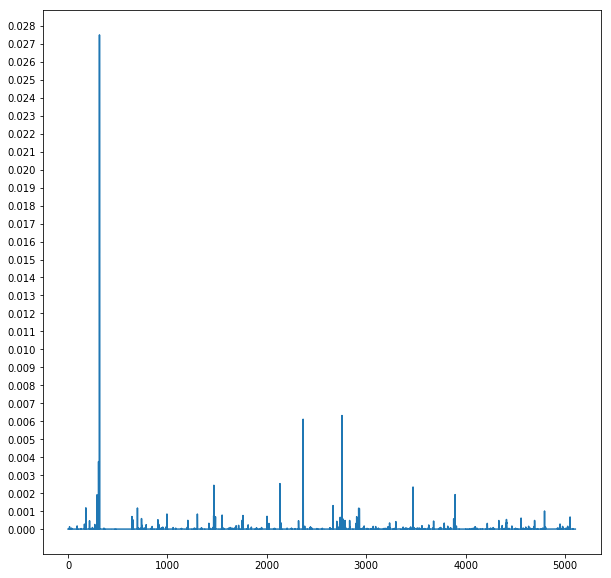

In [5]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=[10,10])
plt.yticks(np.arange(0, 0.1, 0.001))
plt.plot(fr)

In [7]:
thresh = 0.002
stop_words = []
for cfs in reversed(coll_freq_sorted):
    if cfs[3] >= thresh or cfs[3] <= (1/N*1/T):
        print(lab_vocab[cfs[0]-1], cfs[1::])
        for fo in filter_out:
            if lab_vocab[cfs[0]-1][0].find(fo)!=-1:
                stop_words.append(cfs[0])

['icd9::Atypical face pain::350.2::C0154729', 315] [6695, 1023, 0.02749797552788038]
['icd9::Unspecified personality disorder::301.9::C0031212', 2755] [3577, 440, 0.006318967514722309]
['icd9::Routine gynecological examination::V72.31::C1455982', 2364] [3599, 423, 0.006112188227921065]
['icd9::Atrophy of testis::608.3::C0156312', 306] [3491, 268, 0.003756290301143681]
['icd9::Personal history of allergy to analgesic agent::V14.6::C0260490', 2131] [1584, 398, 0.002531120116045324]
['icd9::Need for prophylactic vaccination and inoculation against diptheria-tetanus- pertussis with poliomyelitis [dtp + polio]::V06.3::C0260392', 1466] [1533, 396, 0.0024373160413928906]
['medication::Diphenhydramine hydrochloride::1362::C0004963', 3470] [2137, 273, 0.002342295452675242]
['medication::vaicitra', 5103] [1, 1, 4.014897905000578e-09]
['medication::singular', 5102] [1, 1, 4.014897905000578e-09]
['medication::seizure med', 5101] [1, 1, 4.014897905000578e-09]
['medication::see text entries', 5100] 

In [8]:
print("Discard {0} terms".format(len(stop_words)))

Discard 608 terms


In [9]:
##Write files stop_words.csv and collection_frequencies.csv

with open(os.path.join(folder, 'stop-words.csv'), 'w') as f:
    wr = csv.writer(f, quoting=csv.QUOTE_NONE)
    wr.writerows([stop_words])
    
with open(os.path.join(folder, 'collection-frequencies.csv'), 'w') as f:
    wr = csv.writer(f, quoting=csv.QUOTE_NONE)
    wr.writerow(["EVENT", "COLLECTION_FREQUENCY", "PATIENT_FREQUENCY", "CF*PF"])
    for el in coll_freq:
        wr.writerow(el)